Must download the dataset! Change the directory path as well.

Dataset Link: https://data.mendeley.com/datasets/44p8v6ywsm/1

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the paths to your augmented dataset directory in Google Drive
augmented_data_dir = '/content/drive/MyDrive/CoLeaf_Augmented_Dataset'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121

In [ ]:
# Define parameters
image_height, image_width = 224, 224
batch_size = 32
num_classes = 8
epochs = 50

In [ ]:
# Load and preprocess data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 80% for training, 20% for validation

train_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # specify training subset

validation_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # specify validation subset

Found 3469 images belonging to 8 classes.
Found 862 images belonging to 8 classes.


In [ ]:
# Load the DenseNet121 model without the top layer:
base_model = DenseNet121(input_shape=(224,224,3), include_top=False, weights='imagenet')

In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a Sequential model
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 6: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
108/108 [==============================] - 33s 245ms/step - loss: 1.3616 - accuracy: 0.5284 - val_loss: 1.0445 - val_accuracy: 0.6442
Epoch 2/50
108/108 [==============================] - 23s 214ms/step - loss: 0.8950 - accuracy: 0.7053 - val_loss: 0.8220 - val_accuracy: 0.7248
Epoch 3/50
108/108 [==============================] - 22s 202ms/step - loss: 0.7540 - accuracy: 0.7512 - val_loss: 0.7498 - val_accuracy: 0.7416
Epoch 4/50
108/108 [==============================] - 24s 220ms/step - loss: 0.6801 - accuracy: 0.7748 - val_loss: 0.7120 - val_accuracy: 0.7584
Epoch 5/50
108/108 [==============================] - 22s 208ms/step - loss: 0.6203 - accuracy: 0.7917 - val_loss: 0.6790 - val_accuracy: 0.7596
Epoch 6/50
108/108 [==============================] - 24s 226ms/step - loss: 0.5775 - accuracy: 0.8045 - val_loss: 0.6539 - val_accuracy: 0.7788
Epoch 7/50
108/108 [==============================] - 23s 212ms/step - loss: 0.5495 - accuracy: 0.8193 - val_loss: 0.6314 - val_ac

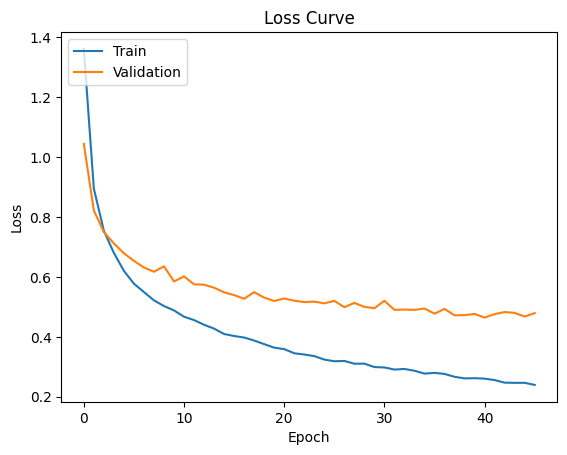

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

27/27 [==============================] - 5s 177ms/step - loss: 0.4777 - accuracy: 0.8248
Validation Loss: 0.4776720702648163, Validation Accuracy: 0.8248260021209717


In [ ]:
# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/CoLeaf/CoLeaf_densenet121.h5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model('/content/drive/MyDrive/CoLeaf/CoLeaf_densenet121.h5')

# Define the class labels based on your training setup
class_labels = ['Boron-B', 'Calcium-Ca', 'Iron-Fe', 'Magnesium-Mg', 'Manganese-Mn', 'Nitrogen-N','Phosphorus-p','Potasium-k']

# Load an image for testing
img_path = '/content/drive/MyDrive/CoLeaf DATASET/calcium-Ca/Ca (10).jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)
predicted_class_name = class_labels[predicted_class]

print(f"The predicted class is: {predicted_class_name} (Class Number: {predicted_class+1})")


1/1 [==============================] - 2s 2s/step
The predicted class is: Calcium-Ca (Class Number: 2)
